follow up to PCA_phenotypes_nicsa only this time taking only traits that have qtls into account, as well as looking at genetic correlation matrix to define phenotypes

# set-up

In [123]:
import pandas as pd
import os
from pca import pca
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import ward, dendrogram, leaves_list, linkage
from scipy.spatial import distance

In [54]:
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/')

In [15]:
nicsa_traits=pd.read_csv('/tscc/projects/ps-palmer/brittany/SUD_cross_species/scripts/nicsa_traits.csv')

# filter traits for qtls

In [7]:
aqtl=pd.read_csv('nicsa_gwas/results/qtls/allQTLS.csv')
qtl=pd.read_csv('nicsa_gwas/results/qtls/finalqtlannotated.csv')

In [12]:
len(aqtl)==len(qtl)
#annotated final==qtl but after snpeff annotation (i think)

True

In [20]:
qtl_t=set(qtl.trait)
#remove the PCA analysis and UMAP traits
qtl_t={x for x in qtl_t if ('pc' not in x) and ('umap' not in x)}

In [30]:
qtl_inactive={x for x in qtl_t if ('inactivelick' in x)}
qtl_inactive

{'nicsa_day10_inactivelick',
 'nicsa_day1_inactivelick',
 'nicsa_day3_inactivelick',
 'nicsa_day4_inactivelick',
 'nicsa_day9_inactivelick',
 'nicsa_total_inactivelick_10days'}

In [31]:
qtl_t=qtl_t-qtl_inactive

In [33]:
qtl_t = [x[len('nicsa_'):] if x.startswith('nicsa_') else x for x in qtl_t]

In [95]:
qtl_t

['day1_infusion',
 'day2_activelick',
 'day6_activelick',
 'day4_infusion',
 'day11_activelick',
 'day8_infusion',
 'last_three_days_infusion_median',
 'day5_infusion',
 'day6_infusion',
 'day8_activelick',
 'total_infusion_10days',
 'slope_nicotine_infusion',
 'day3_active_inactive_ratio',
 'day4_activelick',
 'day4_active_inactive_ratio',
 'day11_active_inactive_ratio',
 'day2_infusion',
 'day6_active_inactive_ratio',
 'day3_activelick',
 'first_three_days_infusion_median',
 'active_inactive_ratio_all_days',
 'total_activelick_10days',
 'day8_active_inactive_ratio',
 'active_inactive_ratio_last_three_median',
 'day1_activelick',
 'day11_infusion']

In [40]:
nicsa_traits['qtl'] = nicsa_traits['trait'].apply(lambda x: True if x in qtl_t else False)

In [50]:
f=((nicsa_traits['parallel']=='cigday') & (nicsa_traits['qtl']==True) )

In [51]:
nicsa_traits[f]

,trait,file_prefix,N,parallel,qtl
11,active_inactive_ratio_last_three_median,regressedlr_nicsa_active_inactive_ratio_last_t...,1950,cigday,True
14,last_three_days_infusion_median,regressedlr_nicsa_last_three_days_infusion_median,1989,cigday,True
16,total_activelick_10days,regressedlr_nicsa_total_activelick_10days,2018,cigday,True
17,total_infusion_10days,regressedlr_nicsa_total_infusion_10days,2018,cigday,True
18,active_inactive_ratio_all_days,regressedlr_nicsa_active_inactive_ratio_all_days,2018,cigday,True


# import phenotypic data

In [55]:
phenopath='nicsa_gwas/data/pheno/'

In [56]:
pheno=pd.read_csv('allpheno.txt',sep='\t',header=None)

In [57]:
#N rats in combined file
len(pheno)

2018

In [61]:
tbl=nicsa_traits[nicsa_traits['qtl']==True]

In [65]:
if 'tbl_cigday' in locals(): 
    del(tbl_cigday)
if 'tbl_smkinit' in locals(): 
    del(tbl_smkinit)
if 'tbl_qtl' in locals(): 
    del(tbl_qtl)
if 'tbl_inactive' in locals(): 
    del(tbl_inactive)   

In [96]:
for f in os.listdir(phenopath):
    if f.endswith('.txt'):
        label=(f[18: (len(f)-4)]) 
        #print(label)
        t=pd.read_csv(phenopath+f,sep=' ',header=None)
        if len(t.columns)==4:
            t=t[[1,2,3]]
        t.columns=['family','RFID',label]
        if (label in list(tbl[tbl.parallel=='cigday'].trait)):
            print(label +' in cigday')
            if 'tbl_cigday' in globals():
                tbl_cigday=tbl_cigday.merge(t[['RFID',label]],on='RFID')
                print('# rats for '+f+': '+str(len(t)))
                print('# rats for tbl_cigday'+': '+str(len(tbl_cigday)))
            else:
                tbl_cigday=t[['RFID',label]]
        elif (label in list(tbl[tbl.parallel!='cigday'].trait)):
            print(label +' in smkinit')
            if 'tbl_smkinit' in globals():
                tbl_smkinit=tbl_smkinit.merge(t[['RFID',label]],on='RFID')
                print('# rats for '+f+': '+str(len(t)))
                print('# rats for tbl_smkinit'+': '+str(len(tbl_smkinit)))
            else:
                tbl_smkinit=t[['RFID',label]]
        elif (label in qtl_t):
            print(label +' has a qtl and is not an inactive lick trait')
            if 'tbl_qtl' in globals():
                tbl_qtl=tbl_qtl.merge(t[['RFID',label]],on='RFID')
                print('# rats for '+f+': '+str(len(t)))
                print('# rats for tbl_qtl'+': '+str(len(tbl_qtl)))
            else:
                tbl_qtl=t[['RFID',label]]
        elif (label in qtl_inactive):
            print(label +' has a qtl and is an inactive lick trait')
            if 'tbl_inactive' in globals():
                tbl_inactive=tbl_qtl.merge(t[['RFID',label]],on='RFID')
                print('# rats for '+f+': '+str(len(t)))
                print('# rats for tbl_inactive'+': '+str(len(tbl_inactive)))
            else:
                tbl_inactive=t[['RFID',label]]
        else:
            print(label+' not in nicsa traits table')

 not in nicsa traits table
day1_inactivelick not in nicsa traits table
day2_inactivelick not in nicsa traits table
day11_active_inactive_ratio has a qtl and is not an inactive lick trait
first_three_days_infusion_median in smkinit
# rats for regressedlr_nicsa_first_three_days_infusion_median.txt: 2018
# rats for tbl_smkinit: 2018
day7_infusion not in nicsa traits table
total_inactivelick_10days not in nicsa traits table
_pc1_no_covariate not in nicsa traits table
active_inactive_ratio_all_days in cigday
# rats for regressedlr_nicsa_active_inactive_ratio_all_days.txt: 2018
# rats for tbl_cigday: 2018
slope_nicotine_infusion has a qtl and is not an inactive lick trait
# rats for regressedlr_nicsa_slope_nicotine_infusion.txt: 2018
# rats for tbl_qtl: 2018
lusters_0 not in nicsa traits table
day3_infusion not in nicsa traits table
day7_activelick not in nicsa traits table
day10_active_inactive_ratio not in nicsa traits table
lusters_1 not in nicsa traits table
day3_active_inactive_ratio ha

# genetic correlation heirarchical clustering

In [118]:
outmixed=pd.read_csv('nicsa_gwas/results/heritability/genetic_correlation_matrix.csv',index_col=0)
outg=pd.read_csv('nicsa_gwas/results/heritability/genetic_correlation_matrix_justgenetic.csv',index_col=0)


In [113]:
outmixed

,umap1,umap_clusters_1,umap_clusters_2,pc2,nicsa_day1_inactivelick,nicsa_day2_inactivelick,nicsa_day11_inactivelick,nicsa_day3_inactivelick,nicsa_day20_inactivelick,nicsa_day5_inactivelick,...,nicsa_day8_infusion,nicsa_day7_infusion,nicsa_day10_activelick,nicsa_day10_infusion,nicsa_day5_activelick,nicsa_day5_infusion,nicsa_day6_activelick,nicsa_day6_infusion,nicsa_slope_nicotine_infusion,pc3
umap1,0.272 +- 0.03,0.5041611164929239 +- 0,0.3987549678470274 +- 0,-0.1956888330194459 +- 0,0.07317042135135757 +- 0,0.06472951294704847 +- 0,-0.02866236925004467 +- 0,0.058072331241810604 +- 0,0.05478613971017397 +- 0,0.0640171150570107 +- 0,...,-0.6175380405226818 +- 0,-0.5968638839733469 +- 0,-0.7056497292546686 +- 0,-0.66579607005653 +- 0,-0.6097503178306368 +- 0,-0.5742861270677292 +- 0,-0.6433508819993595 +- 0,-0.6020537784104196 +- 0,-0.08779855383928678 +- 0,-0.041248273714717856 +- 0
umap_clusters_1,1.0+-0.249523,0.289 +- 0.069,-0.47894667805968044 +- 0,-0.015141746357844899 +- 0,-0.06893764761371586 +- 0,-0.07600958445847697 +- 0,-0.13211509765275167 +- 0,-0.029480228662767127 +- 0,-0.06475414849138268 +- 0,-0.023273536943253768 +- 0,...,-0.34469544496280863 +- 0,-0.28817177019454016 +- 0,-0.36540351584719866 +- 0,-0.35415407369809704 +- 0,-0.3478783985534774 +- 0,-0.32756448642675934 +- 0,-0.33731114174558874 +- 0,-0.34074219476425255 +- 0,-0.03579115031125539 +- 0,-0.012383455994354687 +- 0
umap_clusters_2,1.0+-0.594374,0 +- *,0.052 +- 0.061,-0.013174783272328927 +- 0,0.06749982869820285 +- 0,0.021381444009251786 +- 0,-0.0604439697107787 +- 0,0.024869781802836218 +- 0,-0.026434352972054213 +- 0,-0.054384154928588314 +- 0,...,-0.3220207914669456 +- 0,-0.32007281791946857 +- 0,-0.3488009794909551 +- 0,-0.3585819552237851 +- 0,-0.3086288886939451 +- 0,-0.3206018651171516 +- 0,-0.3249470630535908 +- 0,-0.30779772743201095 +- 0,-0.12125347920255408 +- 0,-0.15526946916226322 +- 0
pc2,-0.241701+-0.095386,-0.202415+-0.188422,-0.741074+-0.703964,0.219 +- 0.03,-0.4931523236030506 +- 0,-0.5364414664470725 +- 0,-0.6099878942875173 +- 0,-0.6211228955185838 +- 0,-0.5112287298894839 +- 0,-0.6682106623047731 +- 0,...,-0.12173613998362975 +- 0,-0.08523174902568738 +- 0,-0.08934564874628906 +- 0,-0.12247521749514118 +- 0,-0.0507808549504754 +- 0,-0.08568613712532107 +- 0,-0.03271685944060174 +- 0,-0.07169939366470048 +- 0,-0.12777986421807372 +- 0,5.282691932927538e-16 +- 0
nicsa_day1_inactivelick,0.228725+-0.11799,0.016469+-0.221757,0.73322+-0.459248,-0.657003+-0.085258,0.126 +- 0.028,0.3793469301025964 +- 0,0.21435412229950587 +- 0,0.3172181913400948 +- 0,0.2112041653543283 +- 0,0.2751062067076497 +- 0,...,0.002725689885387996 +- 0,-0.01018236611264134 +- 0,0.016221385899517486 +- 0,0.0031102561717647717 +- 0,0.011763898857698558 +- 0,0.0023620558805235855 +- 0,-0.0002984805446246422 +- 0,-0.0076095450979688384 +- 0,-0.04682359032390136 +- 0,-0.15295829823773457 +- 0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nicsa_day5_infusion,-0.856442+-0.054652,-0.893045+-0.189825,-1.0+-0.687709,-0.140885+-0.11997,-0.083948+-0.150412,0.190289+-0.140847,0.175114+-0.142741,0.289089+-0.125938,0.185925+-0.156499,0.474989+-0.12451,...,0.834508+-0.080053,0.881153+-0.072019,0.8326+-0.079497,0.767948+-0.083268,1.0+-0.010138,0.144 +- 0.027,0.5287496991148581 +- 0,0.5398034503686704 +- 0,0.005847574746762596 +- 0,0.048845063879143474 +- 0
nicsa_day6_activelick,-0.909616+-0.043107,-0.855058+-0.183436,-1.0+-0.424935,0.188196+-0.118176,-0.276376+-0.13894,-0.131303+-0.139097,0.07166+-0.136799,0.081068+-0.124655,-0.165909+-0.15129,0.089886+-0.14123,...,0.772585+-0.076138,0.80766+-0.069069,0.682895+-0.079899,0.637537+-0.087244,0.884239+-0.056257,0.914371+-0.061101,0.181 +- 0.029,0.9140977235273372 +- 0,0.015187839314126294 +- 0,0.09947763841736518 +- 0
nicsa_day6_infusion,-0.889729+-0.053233,-0.852463+-0.187078,-1.0+-0.471227,0.07302+-0.127005,-0.22273+-0.150667,-0.05611+-0.14907,0.173185+-0.143293,0.160936+-0.131211,-0.072624

In [119]:
outg

,umap1,umap_clusters_1,umap_clusters_2,pc2,nicsa_day1_inactivelick,nicsa_day2_inactivelick,nicsa_day11_inactivelick,nicsa_day3_inactivelick,nicsa_day20_inactivelick,nicsa_day5_inactivelick,...,nicsa_day8_infusion,nicsa_day7_infusion,nicsa_day10_activelick,nicsa_day10_infusion,nicsa_day5_activelick,nicsa_day5_infusion,nicsa_day6_activelick,nicsa_day6_infusion,nicsa_slope_nicotine_infusion,pc3
umap1,1+-0,1.0+-0.249523,1.0+-0.594374,-0.241701+-0.095386,0.228725+-0.11799,0.147025+-0.117045,-0.029279+-0.118699,0.072084+-0.108996,0.148274+-0.128573,-0.010952+-0.12365,...,-0.81045+-0.054845,-0.848479+-0.054228,-0.805142+-0.044175,-0.757538+-0.051968,-0.850127+-0.046082,-0.856442+-0.054652,-0.909616+-0.043107,-0.889729+-0.053233,-0.301232+-0.118467,-0.088208+-0.110599
umap_clusters_1,1.0+-0.249523,1+-0,0 +- *,-0.202415+-0.188422,0.016469+-0.221757,0.175195+-0.214038,-0.341089+-0.194941,-0.013516+-0.195575,-0.206073+-0.224767,0.065012+-0.224571,...,-0.778962+-0.17325,-0.861227+-0.199839,-0.750217+-0.171168,-0.773195+-0.167535,-0.795452+-0.18968,-0.893045+-0.189825,-0.855058+-0.183436,-0.852463+-0.187078,-0.442117+-0.209013,-0.192899+-0.202926
umap_clusters_2,1.0+-0.594374,0 +- *,1+-0,-0.741074+-0.703964,0.73322+-0.459248,0.16672+-0.34725,0.876944+-0.580411,0.362811+-0.343873,0.455454+-0.447807,-0.022816+-0.348016,...,-1.0+-0.819965,-1.0+-0.540838,-1.0+-0.523336,-1.0+-0.717574,-1.0+-0.587923,-1.0+-0.687709,-1.0+-0.424935,-1.0+-0.471227,-0.049145+-0.355813,-0.282481+-0.329715
pc2,-0.241701+-0.095386,-0.202415+-0.188422,-0.741074+-0.703964,1+-0,-0.657003+-0.085258,-0.671854+-0.076152,-0.735837+-0.070575,-0.727126+-0.064589,-0.743552+-0.085204,-0.872693+-0.054986,...,-0.018699+-0.126521,-0.119753+-0.122307,-0.149391+-0.11403,-0.152672+-0.116483,-0.078495+-0.112824,-0.140885+-0.11997,0.188196+-0.118176,0.07302+-0.127005,-0.010091+-0.131926,0.174137+-0.121214
nicsa_day1_inactivelick,0.228725+-0.11799,0.016469+-0.221757,0.73322+-0.459248,-0.657003+-0.085258,1+-0,0.86357+-0.092873,0.509482+-0.142316,0.51994+-0.117534,0.550082+-0.14972,0.462984+-0.141673,...,-0.275689+-0.153077,-0.163239+-0.151783,-0.143763+-0.142984,-0.162012+-0.145818,-0.094928+-0.139417,-0.083948+-0.150412,-0.276376+-0.13894,-0.22273+-0.150667,-0.512203+-0.145852,-0.57831+-0.126463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nicsa_day5_infusion,-0.856442+-0.054652,-0.893045+-0.189825,-1.0+-0.687709,-0.140885+-0.11997,-0.083948+-0.150412,0.190289+-0.140847,0.175114+-0.142741,0.289089+-0.125938,0.185925+-0.156499,0.474989+-0.12451,...,0.834508+-0.080053,0.881153+-0.072019,0.8326+-0.079497,0.767948+-0.083268,1.0+-0.010138,1+-0,0.914371+-0.061101,0.932533+-0.065817,0.371756+-0.152406,0.054302+-0.136779
nicsa_day6_activelick,-0.909616+-0.043107,-0.855058+-0.183436,-1.0+-0.424935,0.188196+-0.118176,-0.276376+-0.13894,-0.131303+-0.139097,0.07166+-0.136799,0.081068+-0.124655,-0.165909+-0.15129,0.089886+-0.14123,...,0.772585+-0.076138,0.80766+-0.069069,0.682895+-0.079899,0.637537+-0.087244,0.884239+-0.056257,0.914371+-0.061101,1+-0,1.0+-0.009995,0.15937+-0.140354,-0.029752+-0.127959
nicsa_day6_infusion,-0.889729+-0.053233,-0.852463+-0.187078,-1.0+-0.471227,0.07302+-0.127005,-0.22273+-0.150667,-0.05611+-0.14907,0.173185+-0.143293,0.160936+-0.131211,-0.072624+-0.162142,0.223457+-0.145824,...,0.817724+-0.078118,0.838754+-0.070353,0.730962+-0.08372,0.666397+-0.090124,0.935223+-0.062753,0.932533+-0.065817,1.0+-0.009995,1+-0,0.204457+-0.150223,-0.056861+-0.137967
nicsa_slope_nicotine_infusion,-0.301232+-0.118467,-0.442117+-0.209013,-0.049145+-0.355813,-0.010091+-0.131926,-0.512203+-0.145852,-0.502907+-0.146214,0.173155+-0.155762,0.035594+-0.145763,0.268458+-0.160882,0.19607+-0.167395,...,0.383223+-0.148055,0.503542+-0.148133,0.415378+-0.134268,0.427553+-0.136794,0.255834+-0.141954,0.371756+-0.152406,0.15937+-0.140354,0.204457+-0.150223,1+-0,0.647382+-0.088446


In [125]:
hieg = linkage(distance.pdist(outg.applymap(lambda x: float(x.split('+-')[0])))) #method='average'
lk = leaves_list(hieg)

In [165]:
pd.DataFrame(hieg)

,0,1,2,3
0,47.0,48.0,0.260673,2.0
1,68.0,69.0,0.301901,2.0
2,42.0,43.0,0.314057,2.0
3,54.0,55.0,0.348181,2.0
4,70.0,71.0,0.379730,2.0
...,...,...,...,...
70,143.0,144.0,2.893739,59.0
71,0.0,145.0,3.117503,3.0
72,142.0,146.0,3.443380,72.0
73,3.0,148.0,3.757465,73.0


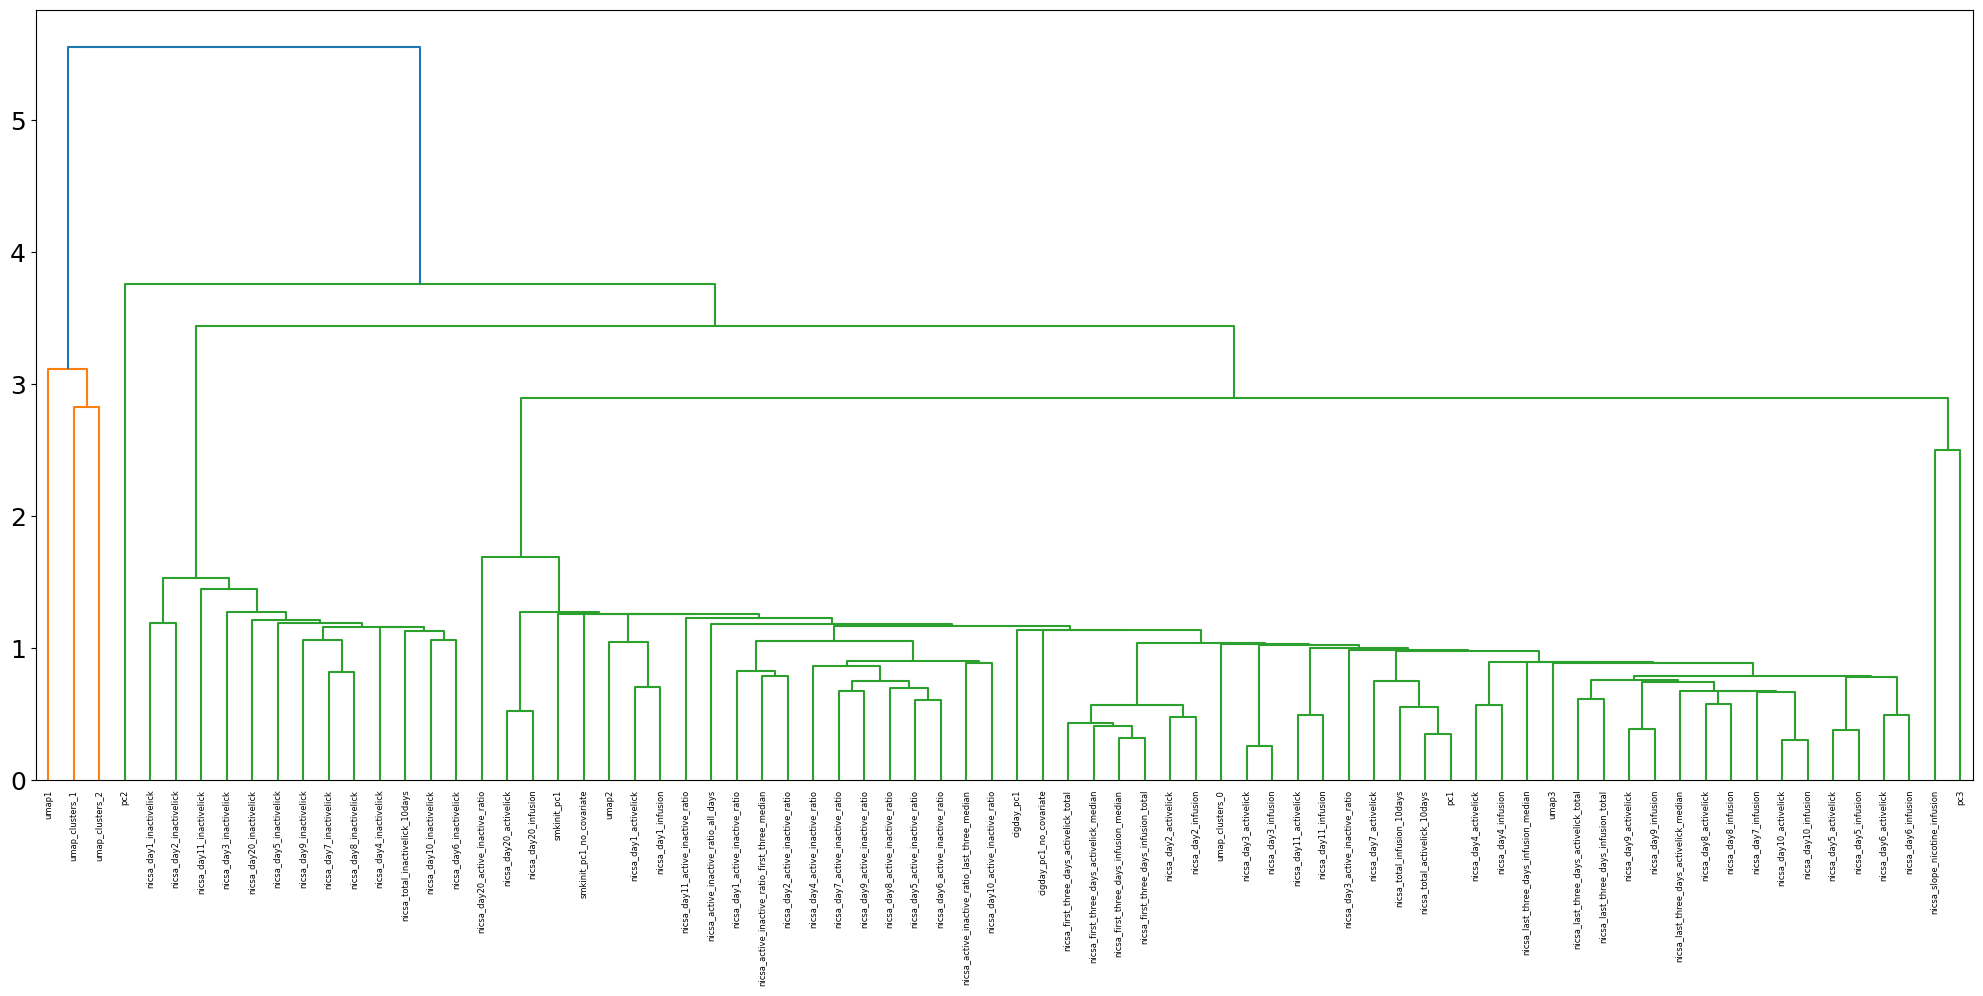

In [169]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(hieg)

In [153]:
plt.figure()
dn = dendrogram(hieg, above_threshold_color="green", color_threshold=.7, orientation='right',ax = a.ax_col_dendrogram)

<Figure size 640x480 with 0 Axes>

In [155]:
a.ax_col_dendrogram

<Axes: >

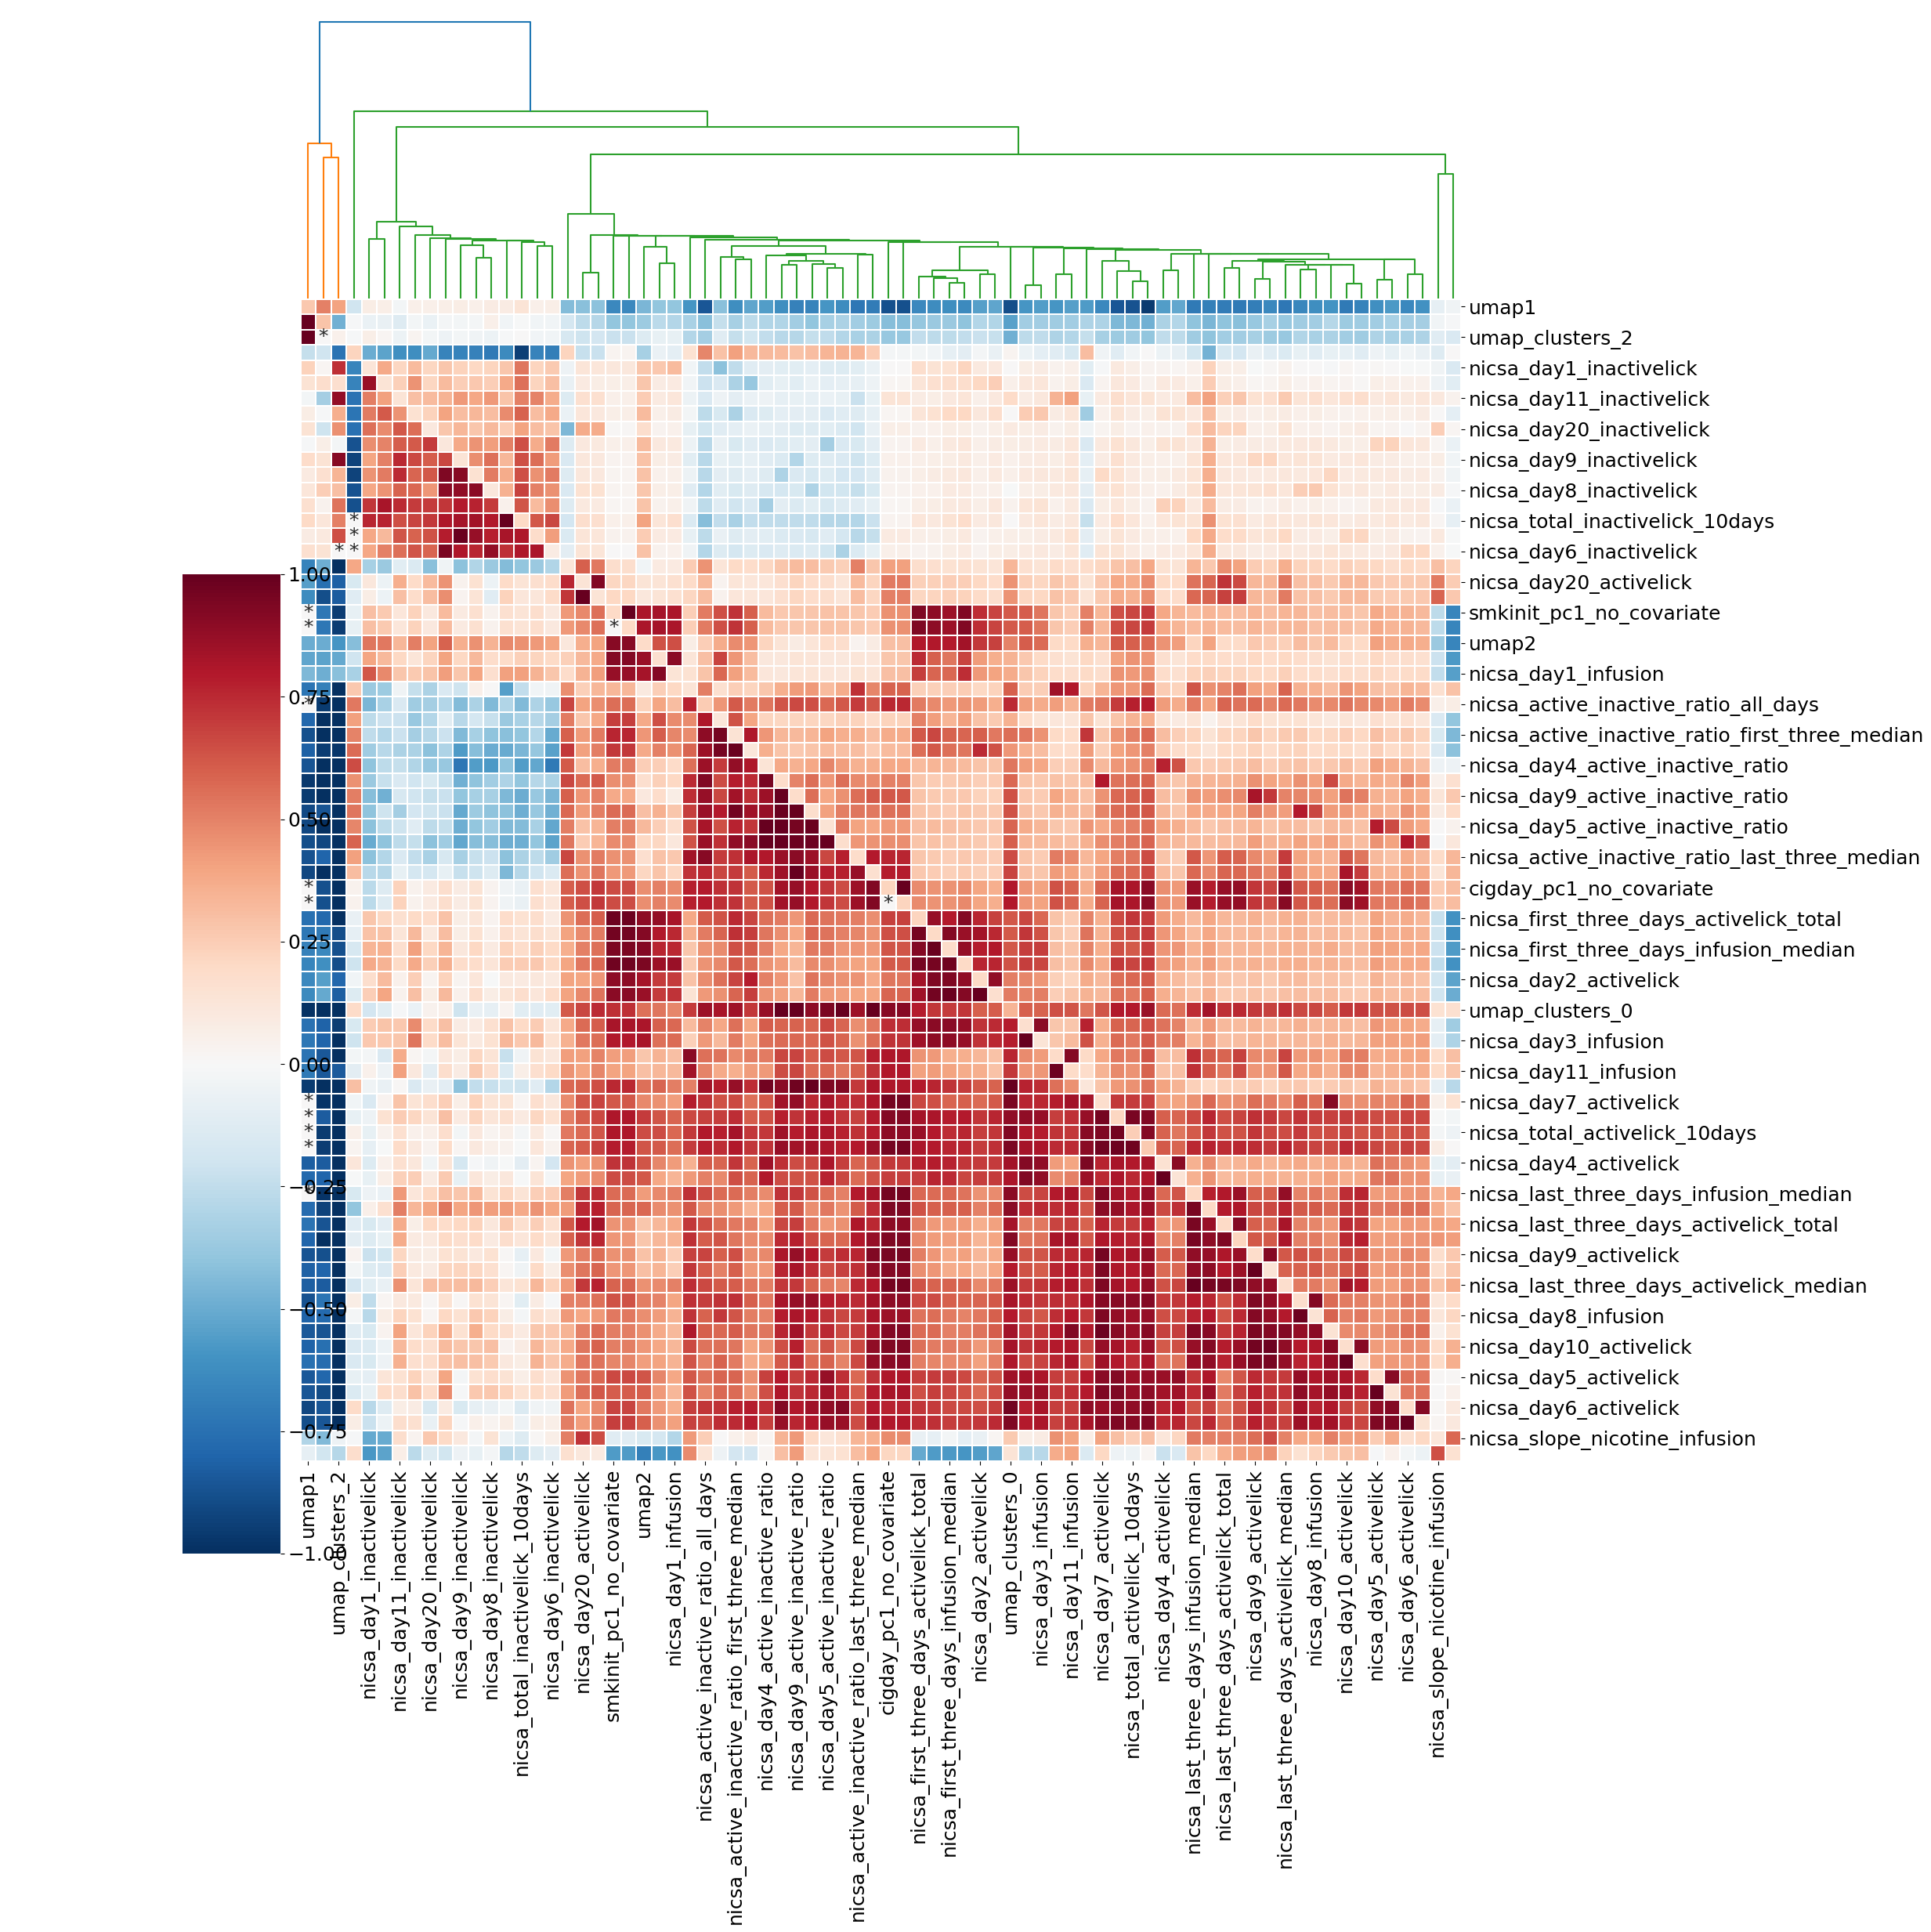

In [168]:
a = sns.clustermap(outmixed.applymap(lambda x: float(x.split('+-')[0])),  cmap="RdBu_r", col_cluster= False, row_cluster=False,
        annot=outmixed.applymap(lambda x: '' if '*' not in x else '*'), vmin =-1, vmax =1, center = 0 , fmt = '', square = True, linewidth = .3, figsize=(25, 25) )
dendrogram(hieg, ax = a.ax_col_dendrogram)
a.ax_cbar.set_position([.1, .2, .05, 0.5])
#plt.savefig(f'{self.path}images/genetic_correlation_matrix.png', dpi = 400)
#plt.savefig(f'{self.path}images/genetic_correlation_matrix.eps')

# PCA analysis -smkinit qtl only

In [67]:
tbl_smkinit

,RFID,first_three_days_infusion_median,day1_activelick,day1_infusion
0,00078A008E,-0.639008,-1.545330,-1.759057
1,0007D2DDED,-0.185069,-1.168650,-0.766195
2,000792A302,-1.162482,0.776632,0.794931
3,00078A256A,0.012434,-0.491235,-0.571181
4,0007D2E752,-0.793341,-1.898319,-1.237739
...,...,...,...,...
2013,0007D3528C,0.690183,-1.273662,-0.847319
2014,00078A19AD,-0.125912,-0.467476,-0.135656
2015,DD1DCD20E6,-0.422556,0.788477,0.422990
2016,DD1DCD218B,1.177271,1.196221,0.590362


In [69]:
df=tbl_smkinit.dropna(axis='rows')

In [70]:
len(df)

2010

In [71]:
labels=list(df.columns[df.columns!=('RFID')])
x = df.loc[:, labels].values
y = df.loc[:,['RFID']].values

In [74]:
model = pca(normalize=True)
# Fit transform and include the column labels and row labels
results_smkinit = model.fit_transform(x, col_labels=labels)

[pca] >Row labels are auto-completed.
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [3] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [2] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [3] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


[scatterd] >INFO> Create scatterplot


(<Figure size 2500x1500 with 1 Axes>,
 <Axes: title={'center': '2 Principal Components explain [100.0%] of the variance'}, xlabel='PC1 (78.6% expl.var)', ylabel='PC2 (18.2% expl.var)'>)

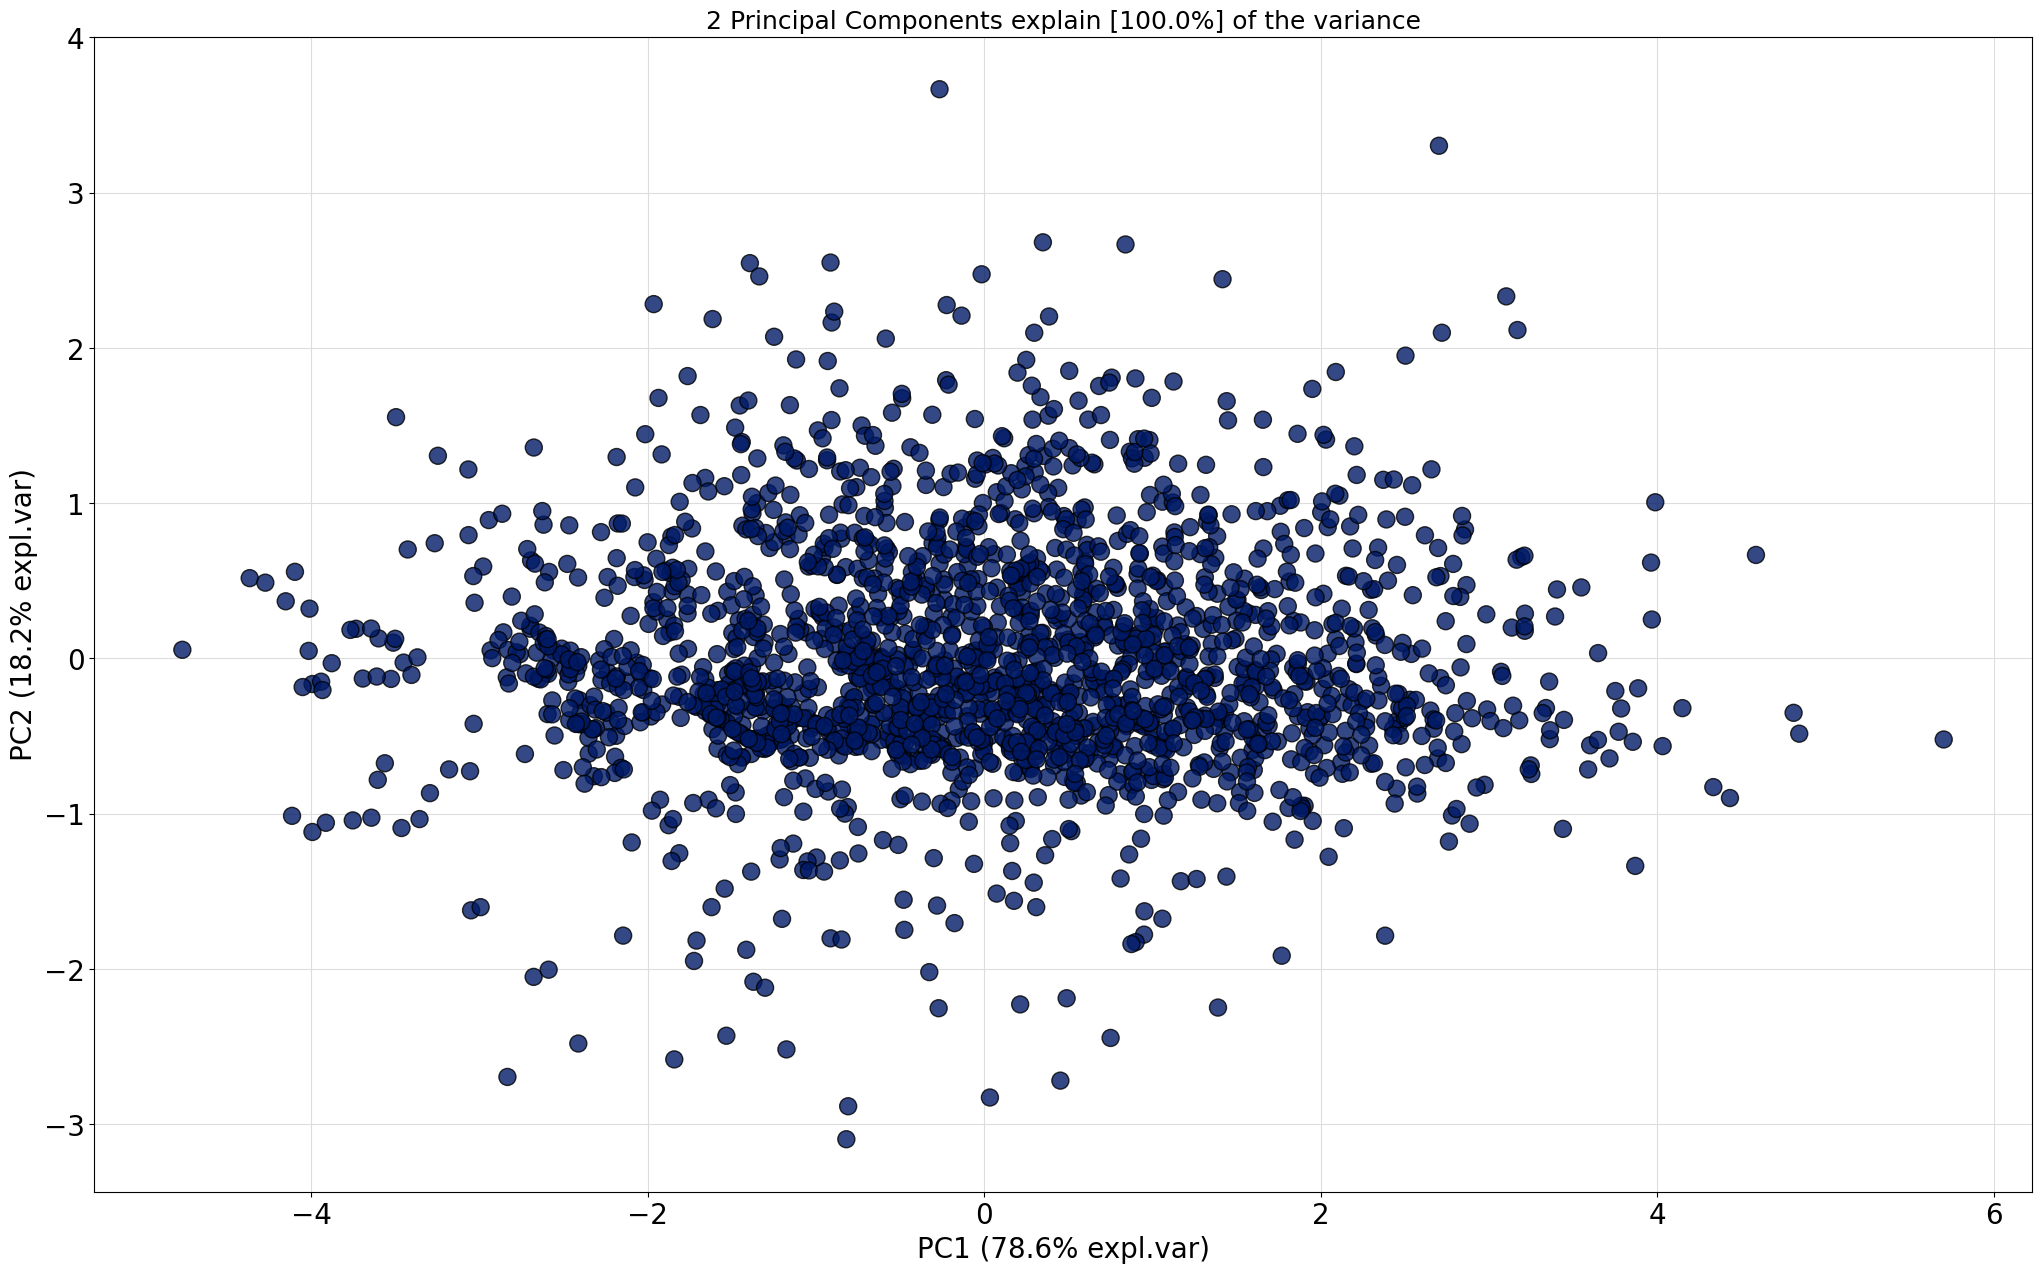

In [75]:
model.scatter()

(<Figure size 1500x1000 with 1 Axes>,
 <Axes: title={'center': 'Cumulative explained variance\n 2 Principal Components explain [100.0%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

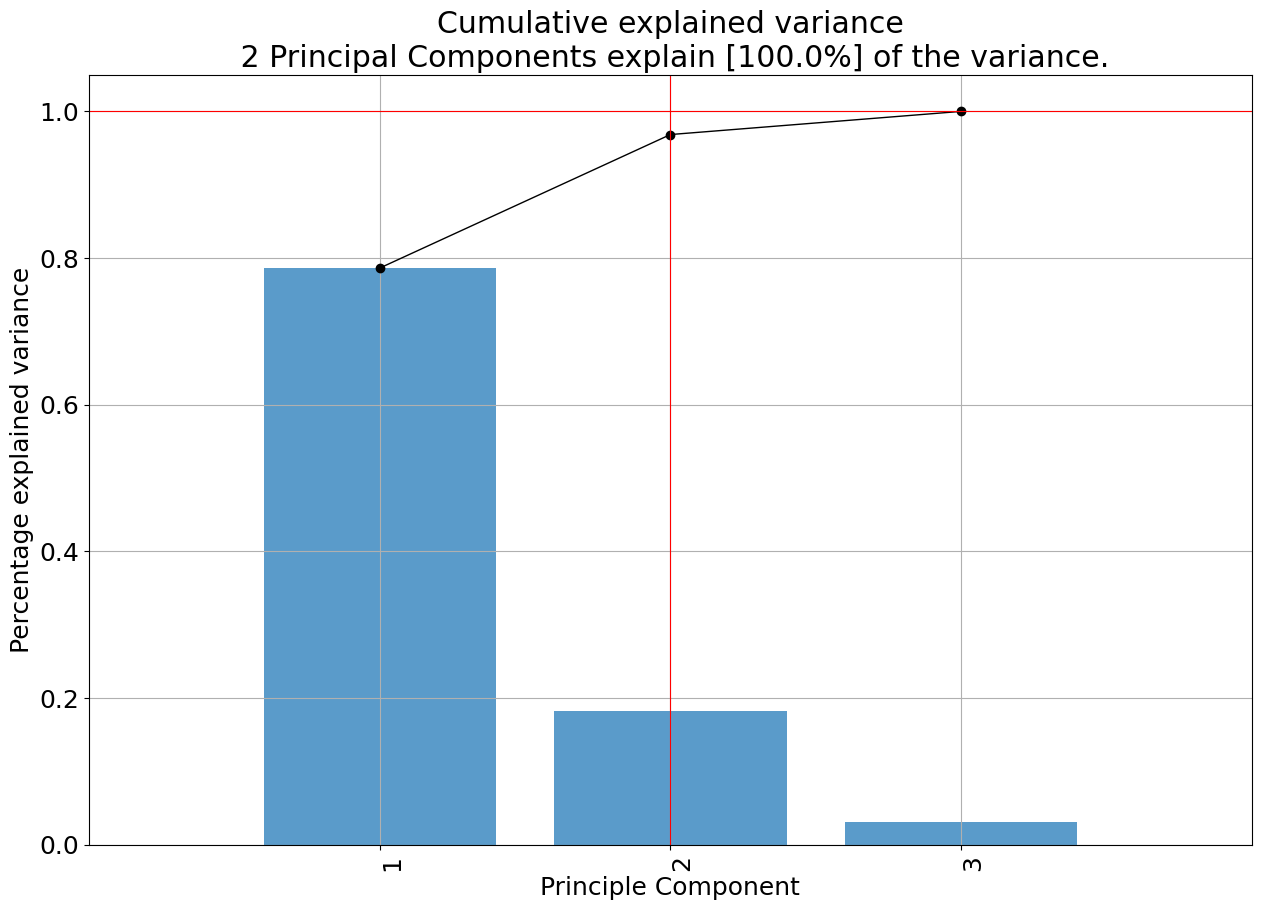

In [76]:
model.plot()

(array([ 18.,  55., 202., 446., 532., 424., 237.,  76.,  17.,   3.]),
 array([-4.76474549, -3.71790445, -2.6710634 , -1.62422236, -0.57738131,
         0.46945973,  1.51630078,  2.56314182,  3.60998287,  4.65682391,
         5.70366496]),
 <BarContainer object of 10 artists>)

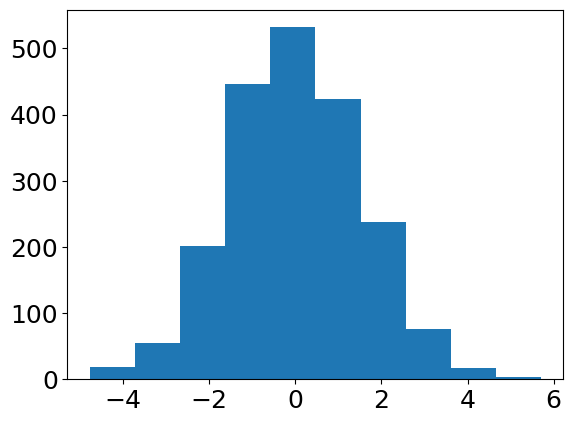

In [77]:
plt.hist(results_smkinit['PC']['PC1'])

# PCA-cigday qtl only

# PCA-all qtl traits

In [98]:
tbl_qtl

,RFID,day11_active_inactive_ratio,slope_nicotine_infusion,day3_active_inactive_ratio,day4_activelick,day6_active_inactive_ratio,day2_infusion,day6_infusion,day3_activelick,day4_active_inactive_ratio,day11_activelick,day11_infusion,day8_active_inactive_ratio,day4_infusion,day8_activelick,day5_infusion,day2_activelick,day6_activelick,day8_infusion
0,00078A008E,0.869424,0.000000,0.607795,1.915384,1.941096,-0.719994,NaN,-0.278078,1.437363,3.281074,2.641420,NaN,1.640956,NaN,NaN,0.854544,3.285700,NaN
1,0007D2DDED,-0.195495,0.418042,-0.638827,0.005054,0.002619,-0.854898,0.979735,0.612282,-0.943771,0.817486,1.121381,-0.916541,0.198387,0.223319,0.253608,-0.719612,0.565521,0.193167
2,000792A302,-0.652077,-0.968083,-0.815331,-2.875627,-0.732358,-0.762847,-0.453267,-0.683588,-2.643857,-0.735140,-0.683448,-0.874746,-2.405983,-0.053619,-0.445532,0.018165,-0.470716,0.239488
3,00078A256A,0.241181,-0.133302,1.696959,NaN,1.633312,0.259558,0.460357,2.022664,1.958214,-0.290468,-0.216383,2.461845,1.869942,0.565299,NaN,0.569944,1.042781,-0.231513
4,0007D2E752,-1.057090,-1.766546,-1.028379,-0.280318,-0.869571,0.683160,-0.229407,-0.066012,-0.993027,-1.458228,-0.969489,-0.172085,-0.269820,-0.181137,-1.322155,0.169292,-0.161346,-0.202395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013,0007D3528C,0.761074,0.060902,0.361621,-0.630717,0.631535,1.734006,0.076731,0.317483,-0.306504,0.551664,0.826239,-1.687846,-0.749379,-1.368851,-0.688806,1.145809,-0.271030,-0.654740
2014,00078A19AD,-0.834262,0.288397,1.063706,0.562774,1.041151,-0.766201,0.397320,0.794219,0.855240,-0.207558,0.081575,-0.511144,0.660282,0.582046,1.483932,-0.540713,0.788652,0.925277
2015,DD1DCD20E6,-1.272446,1.514767,0.008943,-0.476003,-0.030126,-1.254143,0.031945,-0.258540,0.555002,-0.997523,-1.216112,0.178852,-0.812804,0.577463,-0.759278,-0.908114,0.139424,0.880579
2016,DD1DCD218B,-0.057589,0.174785,0.095966,0.698477,-0.614046,1.268008,-0.361621,0.385659,0.290392,0.496642,0.724882,0.274597,0.844866,1.192999,1.049903,0.820740,-0.349988,1.474755


In [97]:
len(tbl_qtl)

2018

In [81]:
df=tbl_cigday.dropna(axis='rows')

In [82]:
labels=list(df.columns[df.columns!=('RFID')])
x = df.loc[:, labels].values
y = df.loc[:,['RFID']].values

In [83]:
model = pca(normalize=True)
# Fit transform and include the column labels and row labels
results_cigday = model.fit_transform(x, col_labels=labels)

[pca] >Row labels are auto-completed.
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [5] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [3] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [5] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[3]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


[scatterd] >INFO> Create scatterplot


(<Figure size 2500x1500 with 1 Axes>,
 <Axes: title={'center': '3 Principal Components explain [99.16%] of the variance'}, xlabel='PC1 (73.1% expl.var)', ylabel='PC2 (12.6% expl.var)'>)

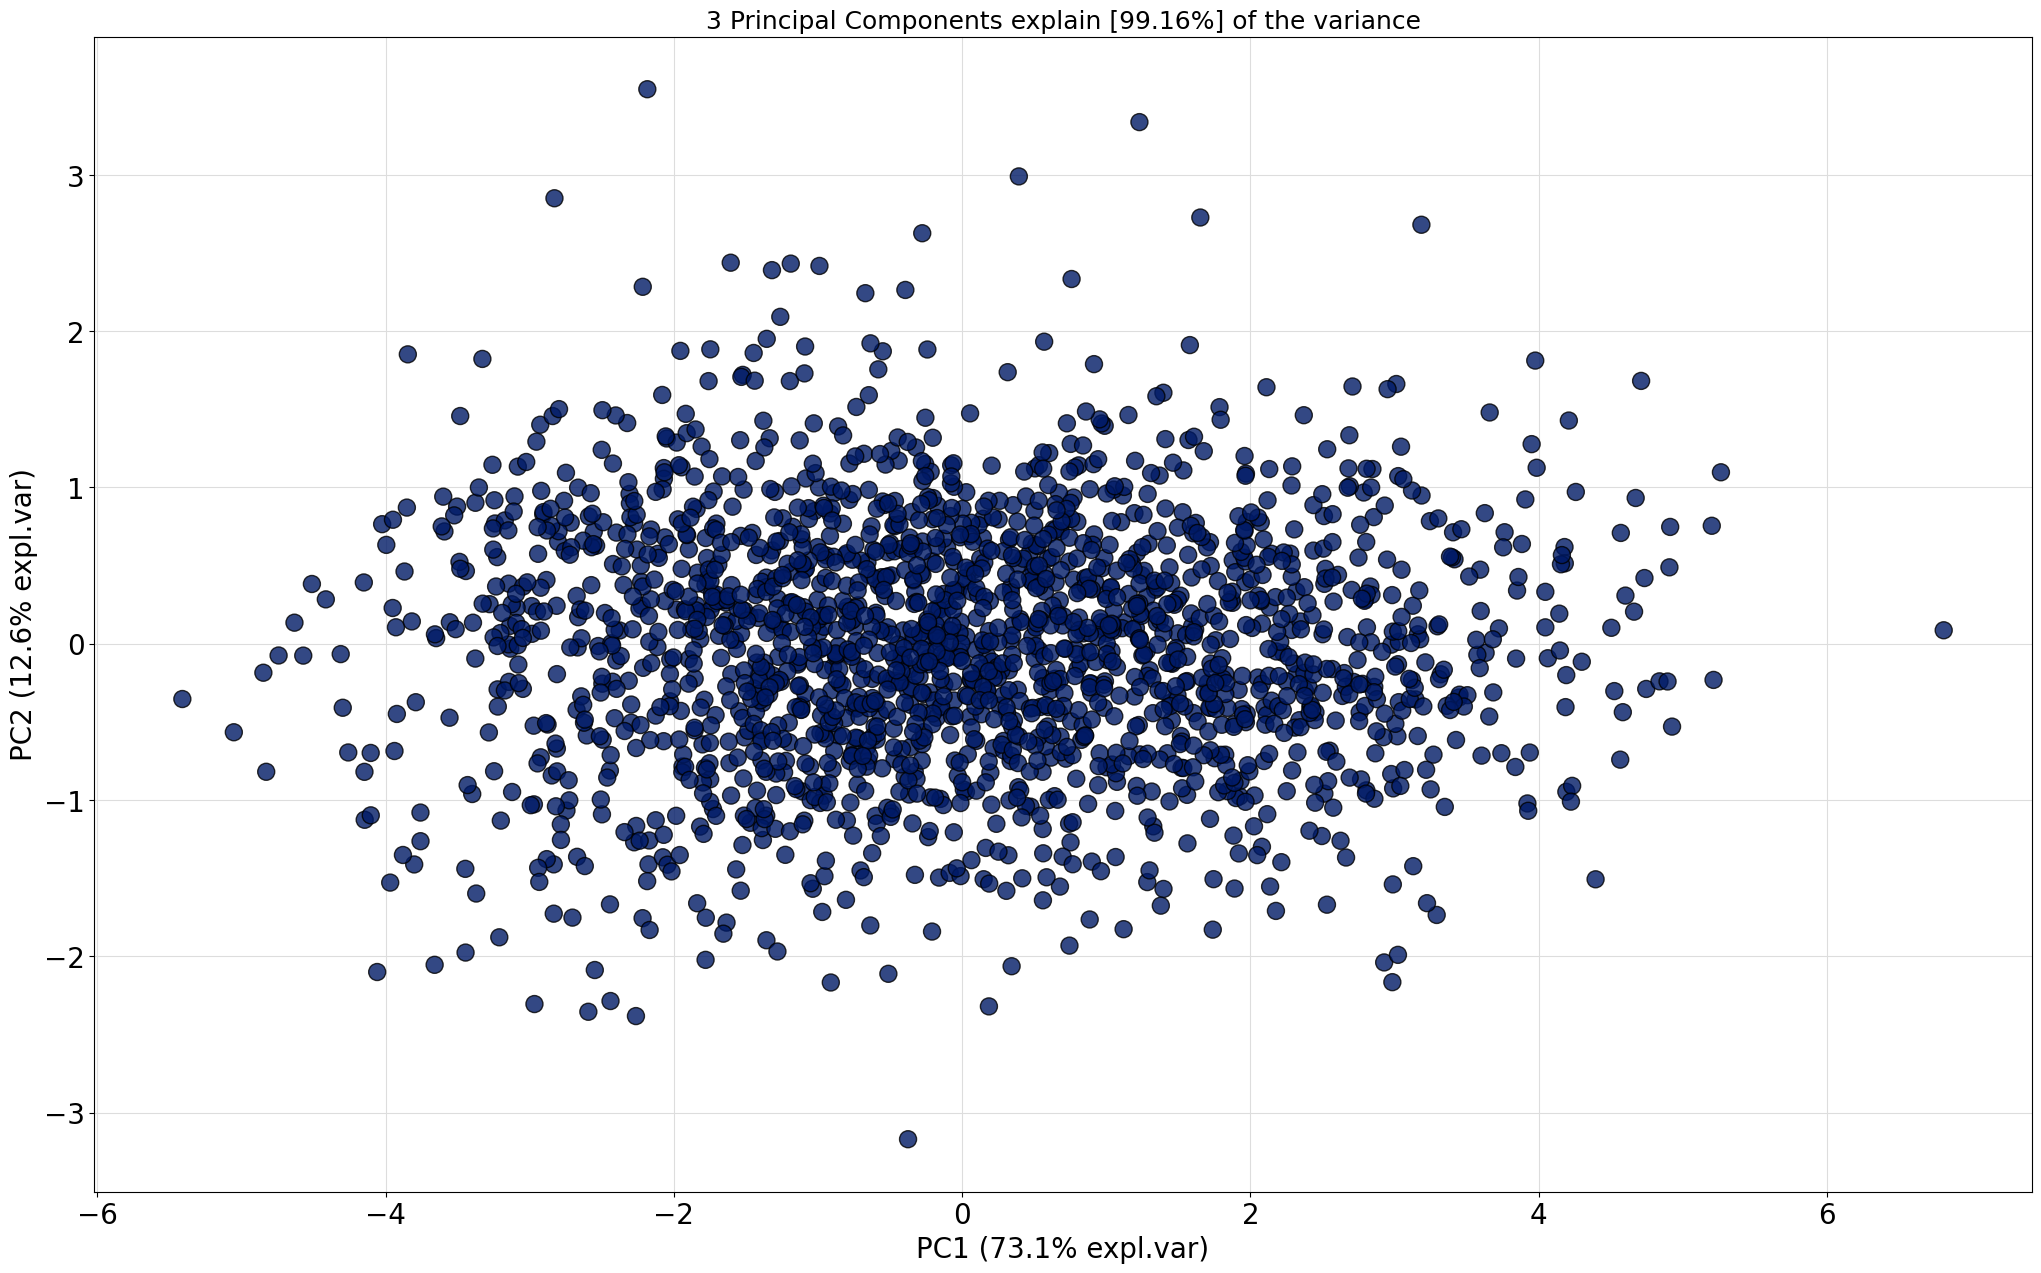

In [84]:
model.scatter()

(<Figure size 1500x1000 with 1 Axes>,
 <Axes: title={'center': 'Cumulative explained variance\n 3 Principal Components explain [99.16%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

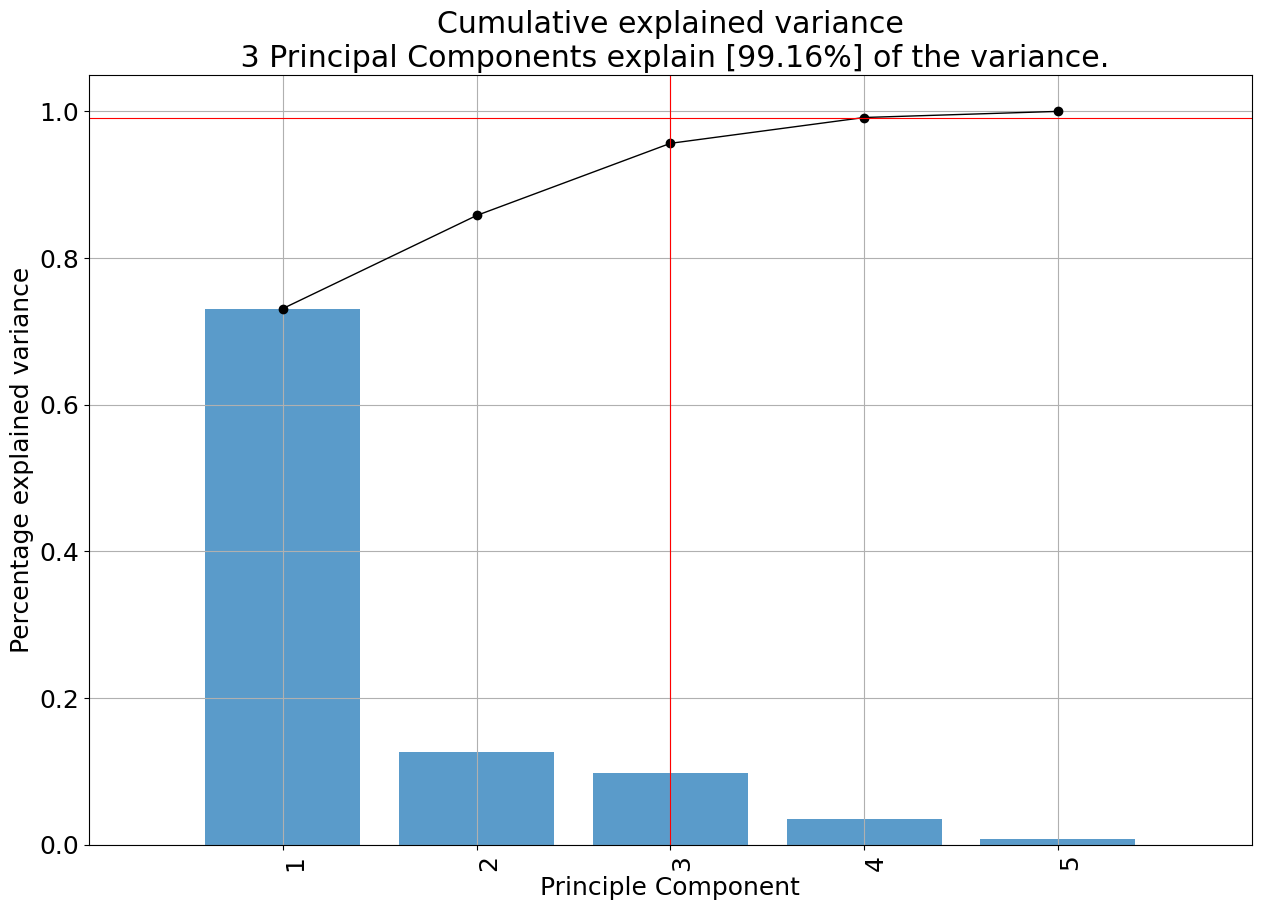

In [85]:
model.plot()

(array([ 18.,  64., 267., 406., 435., 312., 215.,  85.,  27.,   3.]),
 array([-7.83113775, -6.07399914, -4.31686052, -2.55972191, -0.80258329,
         0.95455532,  2.71169394,  4.46883255,  6.22597117,  7.98310978,
         9.7402484 ]),
 <BarContainer object of 10 artists>)

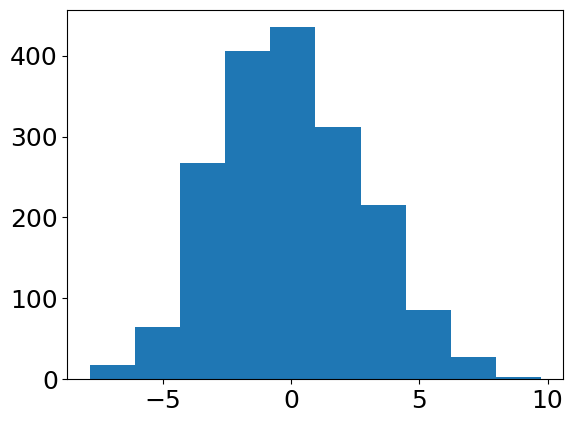

In [26]:
plt.hist(results_cigday['PC']['PC1'])

In [88]:
df['PC1']=results_cigday['PC']['PC1']

/tmp/ipykernel_2747039/3131937238.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PC1']=results_cigday['PC']['PC1']


In [89]:
df

,RFID,active_inactive_ratio_all_days,total_activelick_10days,last_three_days_infusion_median,active_inactive_ratio_last_three_median,total_infusion_10days,PC1
0,00078A008E,0.873542,1.694641,1.050546,0.731658,-0.721617,1.604860
1,0007D2DDED,-1.321812,-0.487290,0.504272,-0.651680,-0.185423,-0.993575
2,000792A302,-1.307085,-0.324032,-0.794103,-1.085261,-0.516865,-1.778902
3,00078A256A,1.195740,0.610014,-0.547668,0.646921,0.968413,1.338782
4,0007D2E752,-2.311552,-1.278453,-1.657158,-1.016094,-1.033994,-3.278601
...,...,...,...,...,...,...,...
2013,0007D3528C,1.046792,0.521127,0.900528,1.029097,1.139292,NaN
2014,00078A19AD,-0.106350,0.294079,0.958743,0.267169,0.622022,NaN
2015,DD1DCD20E6,-0.554123,-0.196802,-0.175990,-1.137681,-0.024212,NaN
2016,DD1DCD218B,-0.061494,0.535401,0.574205,-0.541133,0.862684,NaN


# export pcs

In [90]:
phenopath='nicsa_gwas/data/pheno/'

## export smkinit subset and PCs

In [91]:
len(results_smkinit['PC'])==len(tbl_smkinit.dropna(axis='rows'))

True

In [92]:
output_smkinit=tbl_smkinit.dropna(axis='rows')

In [93]:
output_smkinit.insert(1, "FAMILY", list(output_smkinit['RFID']), True)
output_smkinit.insert(2, "pc1_smkinit", list(results_smkinit['PC']['PC1']), True)

In [94]:
output_smkinit

,RFID,FAMILY,pc1_smkinit,first_three_days_infusion_median,day1_activelick,day1_infusion
0,00078A008E,00078A008E,-2.349764,-0.639008,-1.545330,-1.759057
1,0007D2DDED,0007D2DDED,-1.277382,-0.185069,-1.168650,-0.766195
2,000792A302,000792A302,0.382282,-1.162482,0.776632,0.794931
3,00078A256A,00078A256A,-0.644311,0.012434,-0.491235,-0.571181
4,0007D2E752,0007D2E752,-2.320172,-0.793341,-1.898319,-1.237739
...,...,...,...,...,...,...
2013,0007D3528C,0007D3528C,-0.950957,0.690183,-1.273662,-0.847319
2014,00078A19AD,00078A19AD,-0.430050,-0.125912,-0.467476,-0.135656
2015,DD1DCD20E6,DD1DCD20E6,0.531919,-0.422556,0.788477,0.422990
2016,DD1DCD218B,DD1DCD218B,1.689458,1.177271,1.196221,0.590362


In [ ]:
#confirm plot matches outputted data
plt.figure(figsize=(8,6))
plt.scatter(x=results_allpheno['PC']['PC1'],y=results_allpheno['PC']['PC2'])

In [36]:
for r in output_smkinit.columns[2:]:
    df_out=output_smkinit[['FAMILY','RFID',r]]
    print(df_out.head())
    p=phenopath+'regressedlr_nicsa_subsmkinit_'+r+'.txt'
    print(p)
    df_out.to_csv(p, sep=' ',header=None)

       FAMILY        RFID  PC1_smkinit
0  00077E6638  00077E6638     4.008589
1  00077E66E0  00077E66E0     2.900209
2  00077E6705  00077E6705     1.102695
3  00077E6708  00077E6708     1.184818
4  00077E679B  00077E679B     0.525417
nicsa_gwas/data/pheno/regressedlr_nicsa_subsmkinit_PC1_smkinit.txt
       FAMILY        RFID  first_three_days_infusion_median
0  00077E6638  00077E6638                          0.709242
1  00077E66E0  00077E66E0                         -0.677615
2  00077E6705  00077E6705                          0.579132
3  00077E6708  00077E6708                          0.580603
4  00077E679B  00077E679B                         -0.143478
nicsa_gwas/data/pheno/regressedlr_nicsa_subsmkinit_first_three_days_infusion_median.txt
       FAMILY        RFID  first_three_days_infusion_total
0  00077E6638  00077E6638                         1.057589
1  00077E66E0  00077E66E0                         0.897429
2  00077E6705  00077E6705                         0.363547
3  00077E6708  

## export cigday subset and PCs

In [37]:
len(results_cigday['PC'])==len(tbl_cigday.dropna(axis='rows'))

True

In [38]:
output_cigday=tbl_cigday.dropna(axis='rows')

In [39]:
output_cigday.insert(1, "FAMILY", list(output_cigday['RFID']), True)
output_cigday.insert(2, "pc1_cigday", list(results_cigday['PC']['PC1']), True)

In [40]:
output_cigday

,RFID,FAMILY,PC1_cigday,active_inactive_ratio_all_days,day10_active_inactive_ratio,day10_activelick,total_activelick_10days,last_three_days_infusion_total,day10_infusion,last_three_days_activelick_median,last_three_days_infusion_median,active_inactive_ratio_last_three_median,total_infusion_10days,last_three_days_activelick_total
1,00077E66E0,00077E66E0,0.486831,1.129840,0.804694,-0.194590,0.948758,-0.764155,-0.089922,-0.365722,-0.413286,0.879200,0.729694,-0.796135
3,00077E6708,00077E6708,2.832655,1.400158,0.450453,0.755632,1.345989,0.523973,0.690094,0.753322,0.708891,0.767390,1.237373,0.548342
4,00077E679B,00077E679B,0.863313,-0.341090,0.265566,0.587477,0.051546,0.067715,0.691746,0.470230,0.689590,-0.135963,0.290192,-0.100109
5,00077E68B2,00077E68B2,1.806852,1.772718,0.071891,-0.550731,1.441020,0.637158,-1.065600,0.089552,0.445053,1.623129,1.066317,0.584785
6,00077E7584,00077E7584,1.729983,0.954616,-0.031556,-0.193263,0.400946,1.070712,-0.088616,0.676864,1.586779,0.763945,-0.327960,0.686619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010,DD1DCD24E2,DD1DCD24E2,0.950166,-0.118844,0.871460,0.528139,-0.005587,0.066470,-0.092536,0.720273,-0.427045,0.943424,0.097614,0.386190
2011,DD1DCD24E4,DD1DCD24E4,0.153387,-0.478919,1.069268,-0.370984,0.162734,-0.251553,-0.352027,-0.400970,0.028975,1.160052,0.415791,-0.395570
2014,DD1DCD24FC,DD1DCD24FC,3.169492,1.044647,0.720293,0.930315,1.156083,0.731316,0.752562,1.176999,0.906211,0.832866,1.141671,0.785950
2015,DD1DCD2503,DD1DCD2503,-0.831816,-0.954616,0.019469,0.417430,-0.452627,-0.250271,0.688444,-0.782074,0.030235,-0.963667,-0.254116,-0.492890


In [41]:
for r in output_cigday.columns[2:]:
    df_out=output_cigday[['FAMILY','RFID',r]]
    print(df_out.head())
    p=phenopath+'regressedlr_nicsa_subcigday_'+r+'.txt'
    print(p)
    df_out.to_csv(p, sep=' ',header=None)

       FAMILY        RFID  PC1_cigday
1  00077E66E0  00077E66E0    0.486831
3  00077E6708  00077E6708    2.832655
4  00077E679B  00077E679B    0.863313
5  00077E68B2  00077E68B2    1.806852
6  00077E7584  00077E7584    1.729983
nicsa_gwas/data/pheno/regressedlr_nicsa_subcigday_PC1_cigday.txt
       FAMILY        RFID  active_inactive_ratio_all_days
1  00077E66E0  00077E66E0                        1.129840
3  00077E6708  00077E6708                        1.400158
4  00077E679B  00077E679B                       -0.341090
5  00077E68B2  00077E68B2                        1.772718
6  00077E7584  00077E7584                        0.954616
nicsa_gwas/data/pheno/regressedlr_nicsa_subcigday_active_inactive_ratio_all_days.txt
       FAMILY        RFID  day10_active_inactive_ratio
1  00077E66E0  00077E66E0                     0.804694
3  00077E6708  00077E6708                     0.450453
4  00077E679B  00077E679B                     0.265566
5  00077E68B2  00077E68B2                     0.071891